# Klasifikacija

Glavni cilj ovog istraživanja je identifikacija polovnih vozila niskog kvaliteta koji kod kupaca izazivaju nezadovoljstvo, a prodavci trpe velike gubitke.

Algoritmi klasifikacije koji su korišćeni u ovom radu su:
 + Naivni Bajes
 + K najbližih suseda
 + Stabla odlučivanja
 + Logistička regresija
 + Algoritmi ansambli: 
     * Voting
     * Stacking
     * Bagging
     * Random forest
     * Gradient boosting
     
Prilikom validacije modela korišćena je unakrsna validacija kao najrealniji pokazatelj rezultata modela.
Izabrana mera evaluacije je AUC zato što ona uzima u obzir vise različitih vrednosti za granicu odlučivanja i kao takva, sveobuhvatnija je u odnosu na ostale mere, kao što je na primer tačnost.

In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import sklearn
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("data/SredjeniPodaci.csv", index_col=0)

In [3]:
X = df.iloc[:, :-1] 
y = df.iloc[:, -1] 

In [4]:
# Pravljenje tabele koja ce sadržati rezultate
results = pd.DataFrame(columns = ['Model'])
results['Model'] = ['Naive Bayes', 'K neighbors', 'Decision tree', 'Logistic regression',
                   'Voting', 'Stacking', 'Bagging NB', 'Random forest', 'Gradient boosting']
results = results.set_index('Model')
results

""
Model
Naive Bayes
K neighbors
Decision tree
Logistic regression
Voting
Stacking
Bagging NB
Random forest
Gradient boosting


In [5]:
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import VotingClassifier
from mlxtend.classifier import StackingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

#### Naivni Bajes
Ovaj algoritam vrši klasifikaciju računajući verovatnoće pripadnosti jednoj klasi na osnovu ulaznih varijabli
    
#### K najbližih suseda
Raspoređuje instancu u klasu koja je najčešća kod njenih K najbližih suseda

####  Stablo odlučivanja
Ovaj algoritam vrši klasifikaciju pravljenjem skupa AKO-ONDA pravila i preteći njih dolazi do rešenja.

#### Logistička regresija
Pronalazi funkciju kojom se najbolje moguće razdvajaju elementi različitih klasa u prostoru i na osnovu nje vrši klasifikaciju
    
#### Algoritmi ansambli:    
* **Glasanje (Voting)**

   Objedinjuje rezultate vise algoritama i na osnovu pravila većine donosi odluku. U ovoj klisifikaciji algoritmu glasanja    su prosleđeni modeli: Naivni Bajes, K najbližih suseda, Stablo odlučivanja i Logistička regresija
        
* **Stacking**

   Algoritam koji ima sposobnost učenja kada je koji algoritam bolji. Isti modeli su mu prosleđeni kao i algoritmu Glasanje
                
* **Bagging (Bootstrap Aggregating)**

   Uzorkuje podatke sa ponavljanjem više puta. Izabran Base estimator za ovaj algoritam je Naivni Bajes.

* **Algoritam nasumičnih šuma (Random Forest)**

   Pripada klasi bagging ansambl algoritama i radi uzorkovanje sa ponavljanjem i slučajeva i atributa, a bazni algoritam 
   mu je Stablo odlučivanja
     
     
* **Gradient Boosting Tree**

   Unapređuje greške prethodnih koraka        

In [6]:
model_nb = GaussianNB()
model_knn = KNeighborsClassifier()
model_tree = DecisionTreeClassifier()
model_lr = LogisticRegression()

model_Voting = VotingClassifier(voting='soft', 
                         estimators=[('nb', model_nb),
                                     ('knn', model_knn),
                                     ('tree', model_tree), 
                                     ('lr', model_lr)])
model_stacking = StackingClassifier(classifiers=[model_nb, model_knn, model_tree, model_lr],
                                    meta_classifier = model_lr,
                                    use_probas=True)
model_bagging = BaggingClassifier(base_estimator=model_nb, bootstrap=20)
model_rf = RandomForestClassifier(n_estimators=100, oob_score=True)
model_GB = GradientBoostingClassifier(n_estimators = 100)
res = list()
for model, label in zip([model_nb, model_knn, model_tree, model_lr, model_Voting, model_stacking, model_bagging, model_rf, model_GB], 
                        ['Naive Bayes', 'K neighbors', 'Decision tree', 'Logistic regression', 'Voting', 'Stacking', 'Bagging NB', 'Random forest', 'Gradient boosting']):
    scores = cross_val_score(model, X, y, cv=10, scoring='roc_auc')
    print(f'{label}: AUC = {round(np.mean(scores)*100, 2)}% +/- {round(np.std(scores)*100, 2)}%')
    res.append(round(np.mean(scores)*100, 2))
results['CV'] = res

Naive Bayes: AUC = 63.24% +/- 2.31%
K neighbors: AUC = 54.66% +/- 2.14%
Decision tree: AUC = 53.26% +/- 2.29%
Logistic regression: AUC = 62.1% +/- 3.26%
Voting: AUC = 63.04% +/- 2.91%
Stacking: AUC = 60.83% +/- 2.84%
Bagging NB: AUC = 63.33% +/- 2.39%
Random forest: AUC = 64.38% +/- 3.55%
Gradient boosting: AUC = 67.09% +/- 4.05%


Rezultati svih algoritama su prilično ujednačeni i varijanse svakog modela su relativno male. Iz dalje analize biće izbačeni modeli K najbližih suseda, Stablo odlučivanja i Stackig jer su pokazali najlošije rezultate, a i da bi se ubrzala dalja analiza.

In [7]:
results

,CV
Model,
Naive Bayes,63.24
K neighbors,54.66
Decision tree,53.26
Logistic regression,62.10
Voting,63.04
Stacking,60.83
Bagging NB,63.33
Random forest,64.38
Gradient boosting,67.09


In [8]:
results = results.drop([results.index[1] , results.index[2], results.index[5]])
results

,CV
Model,
Naive Bayes,63.24
Logistic regression,62.10
Voting,63.04
Bagging NB,63.33
Random forest,64.38
Gradient boosting,67.09


## Selekcija atributa

Prilikom selekcije atributa korišćene su tri metode:
    * Filter metoda - mutual_info_classif
    * Obavijajuća metoda (Wrapper)
    * Ugrađena metoda (Embedded)

In [9]:
# iz modela Voting su izbačeni algoritmi k najbližih suseda i stablo odlučivanja jer su imali lošije rezultate
model_Voting = VotingClassifier(voting='soft', estimators=[('nb', model_nb),('lr', model_lr)])

In [10]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest

In [11]:
selection = SelectKBest(k=50, score_func=mutual_info_classif) 
selection.fit(X, y)
X_reduced_F = X.loc[:, selection.get_support()]

In [12]:
res = list()
for model, label in zip([model_nb, model_lr, model_Voting, model_bagging, model_rf, model_GB], 
                        ['Naive Bayes','Logistic regression', 'Voting', 'Bagging NB', 'Random forest', 'Gradient boosting']):
    
    scores = cross_val_score(model, X_reduced_F, y, cv=10, scoring='roc_auc')
    print(f'{label}: AUC = {round(np.mean(scores)*100, 2)}% +/- {round(np.std(scores)*100, 2)}%')
    res.append(round(np.mean(scores)*100, 2))
results['Filter'] = res

Naive Bayes: AUC = 62.4% +/- 3.56%
Logistic regression: AUC = 60.86% +/- 3.46%
Voting: AUC = 62.78% +/- 3.59%
Bagging NB: AUC = 62.56% +/- 3.63%
Random forest: AUC = 62.82% +/- 3.21%
Gradient boosting: AUC = 65.77% +/- 3.85%


In [13]:
results

,CV,Filter
Model,,
Naive Bayes,63.24,62.40
Logistic regression,62.10,60.86
Voting,63.04,62.78
Bagging NB,63.33,62.56
Random forest,64.38,62.82
Gradient boosting,67.09,65.77


Pomoću filter metode izabrano je 50 atributa sa najvećom entropijom i izvršena je klasifikacija sa takvim skupom atributa.
Rezultati se nisu mnogo promenili, uglavnom su opali ali se proces računanja znatno ubrzao sa manjim brojem atributa.

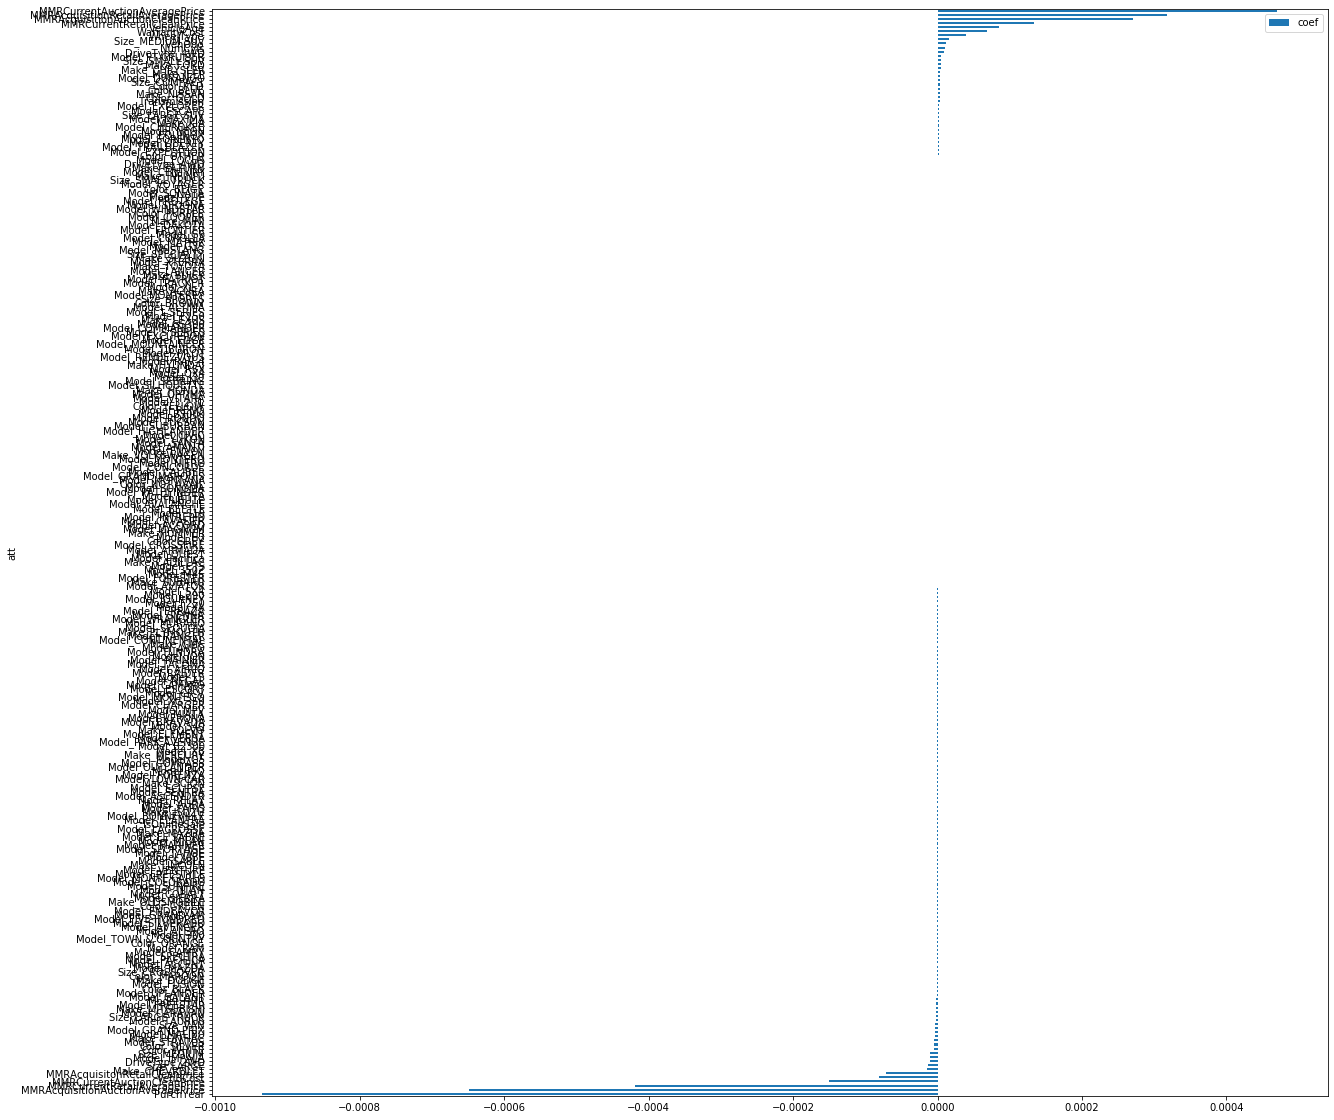

In [14]:
model = LogisticRegression()
model.fit(X, y)

coefs = pd.DataFrame({'att':X.columns, 'coef':model.coef_[0,:]}).sort_values(by='coef',ascending=True).replace(0,np.nan).dropna()
coefs.replace(0,np.nan).dropna().plot.barh(x='att',y='coef',figsize=(20, 20))

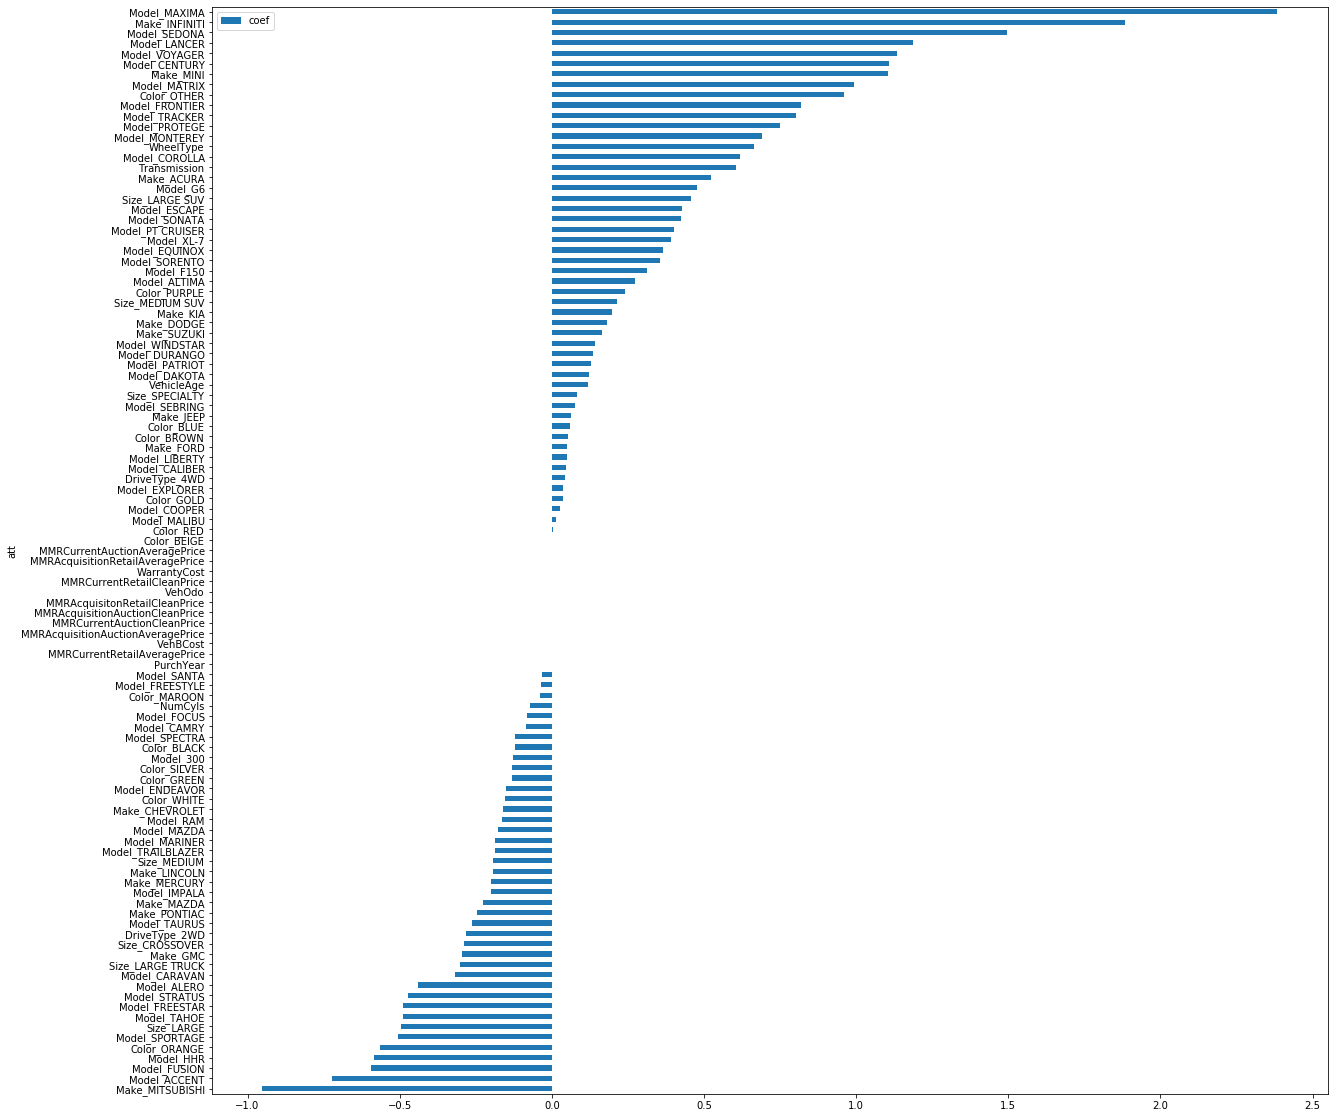

In [15]:
model = LogisticRegression(penalty='l1', solver='liblinear')
model.fit(X, y)

coefs = pd.DataFrame({'att':X.columns, 'coef':model.coef_[0,:]}).sort_values(by='coef',ascending=True).replace(0,np.nan).dropna()
coefs.replace(0,np.nan).dropna().plot.barh(x='att',y='coef',figsize=(20, 20))

Pomoću logističke regresije izračunato je koji atributi imaju veliku uticaj na model i može se primetiti da većina ima mali  uticaj što nam daje mogućnost da dosta atributa izostavimo iz modela kako ne bismo povećavali kompleksnost modela.

In [16]:
from sklearn.feature_selection import RFECV

model = LogisticRegression()
model_as = RFECV(estimator=model, 
                 min_features_to_select=20, cv=10, step=1, 
                 scoring='roc_auc')
model_as.fit(X, y)
X_reduced_W = X.loc[:, model_as.get_support()]

In [17]:
res = list()
for model, label in zip([model_nb, model_lr, model_Voting, model_bagging, model_rf, model_GB], 
                        ['Naive Bayes','Logistic regression', 'Voting', 'Bagging NB', 'Random forest', 'Gradient boosting']):
    
    scores = cross_val_score(model, X_reduced_W, y, cv=10, scoring='roc_auc')
    print(f'{label}: AUC = {round(np.mean(scores)*100, 2)}% +/- {round(np.std(scores)*100, 2)}%')
    res.append(round(np.mean(scores)*100, 2))
results['Wrapper'] = res

Naive Bayes: AUC = 63.32% +/- 2.33%
Logistic regression: AUC = 62.09% +/- 3.28%
Voting: AUC = 63.46% +/- 2.92%
Bagging NB: AUC = 63.5% +/- 2.4%
Random forest: AUC = 64.44% +/- 3.61%
Gradient boosting: AUC = 67.07% +/- 4.15%


In [18]:
results

,CV,Filter,Wrapper
Model,,,
Naive Bayes,63.24,62.40,63.32
Logistic regression,62.10,60.86,62.09
Voting,63.04,62.78,63.46
Bagging NB,63.33,62.56,63.50
Random forest,64.38,62.82,64.44
Gradient boosting,67.09,65.77,67.07


Pomoću Wrapper metode primenjene na Logističkoj regresiji određeno je koji atributi i koje njihove kombinacije su najpogodnije za model i na osnovu te selekcije izvršena je analiza svih ostalih modela sa redukovanim skupom atributa. Rezultati se ponovo nisu mnogo promenili ali bolji su nego kod klasifikacije koja je izvršena na selektovanim podacima pomoću filter metode.

In [19]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegressionCV

model_lr = LogisticRegressionCV(penalty='l1', scoring = "roc_auc", solver = 'saga')
sfm = SelectFromModel(model_lr)
sfm.fit(X, y)
X_reduced_E = X.loc[:, sfm.get_support()]

In [20]:
res = list()
for model, label in zip([model_nb, model_lr, model_Voting, model_bagging, model_rf, model_GB], 
                        ['Naive Bayes', 'Logistic regression', 'Voting', 'Bagging NB', 'Random forest', 'Gradient boosting']):
    
    scores = cross_val_score(model, X_reduced_E, y, cv=10, scoring='roc_auc')
    print(f'{label}: AUC = {round(np.mean(scores)*100, 2)}% +/- {round(np.std(scores)*100, 2)}%')
    res.append(round(np.mean(scores)*100, 2))
results['Embedded'] = res

Naive Bayes: AUC = 60.74% +/- 2.22%
Logistic regression: AUC = 61.96% +/- 3.25%
Voting: AUC = 61.66% +/- 2.69%
Bagging NB: AUC = 60.78% +/- 2.28%
Random forest: AUC = 59.66% +/- 3.25%
Gradient boosting: AUC = 61.73% +/- 3.07%


In [21]:
results

,CV,Filter,Wrapper,Embedded
Model,,,,
Naive Bayes,63.24,62.40,63.32,60.74
Logistic regression,62.10,60.86,62.09,61.96
Voting,63.04,62.78,63.46,61.66
Bagging NB,63.33,62.56,63.50,60.78
Random forest,64.38,62.82,64.44,59.66
Gradient boosting,67.09,65.77,67.07,61.73


Selekcija podataka izvršena je i pomoću Ugrađene metode primenjene na Logističkoj regresiji koja je vršila selekciju unutar samog algoritma. Na osnovu navedenih rezultata Wrapper metoda selekcije atributa se izdvaja kao najbolja i zato će optimizacija parametara u narednom delu da se radi pomoću ovako selektovanih atributa.

## Optimizacija parametara

Prilikom optimiziacije parametara korišćena je ne-iscrpna pretraga (non-exhaustive search) radi uštede vremena i povećane efikasnosti.
Optimizacija se vršila za četiri algoritma i to su:
    * LogisticRegression
    * Bagging
    * RandomForest
    * GradientBoosting
    
Za logističku regresiju menjani su parametri: penalty i C.

Za Bagging algoritam menjani su parametri: n_estimators, bootstrap, max_samples i max_features

Kod RandomForest algoritma menjani su parametri: n_estimators, max_depth, min_samples_leaf i criterion

A za GradientBoosting razmatrani su sledeći parametri:  loss, n_estimators i learning_rate

In [22]:
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats

In [23]:
params = {"penalty": ['l1', 'l2'],
          "C": scipy.stats.uniform(0.0001,2),
          "solver" : ['liblinear']}
n_iter_search = 100
random_search = RandomizedSearchCV(LogisticRegression(), 
                                   param_distributions=params,
                                   n_iter=n_iter_search, cv=5, scoring='roc_auc')
random_search.fit(X_reduced_W,y)
f'Najbolji parametri: {random_search.best_params_} najbolji rezultat AUC =  {random_search.best_score_}'

"Najbolji parametri: {'C': 1.937645580639642, 'penalty': 'l1', 'solver': 'liblinear'} najbolji rezultat AUC =  0.6736255166302705"

Optimalni parametri su Logističke regresije su:
* C = 1.94
* penalty = l1
* solver = liblinear

I najbolja AUC vrednost za ovaj algoritam je 67.36%.

In [24]:
grid_params = {
    'n_estimators' : [50, 100, 120],
    'bootstrap' : [10, 20, 30],
    'max_samples' : scipy.stats.uniform(0.0001,1),
    'max_features' : scipy.stats.uniform(0.0001,1)
}
random_search = RandomizedSearchCV(
    BaggingClassifier(),
    grid_params,
    scoring="roc_auc",
    cv = 10)
random_search.fit(X_reduced_W, y)
f'Najbolji parametri: {random_search.best_params_} najbolji rezultat AUC =  {random_search.best_score_}'

"Najbolji parametri: {'bootstrap': 20, 'max_features': 0.9589479293954285, 'max_samples': 0.423266630087313, 'n_estimators': 100} najbolji rezultat AUC =  0.6484904397145254"

Optimalne vrednosti su  BaggingClassifier algoritma su:
* n estimators = 100
* bootstrap = 20
* max samples = 0.4233
* max features = 0.9589

I najbolja AUC pronađena vrednost je 64.85%.

In [25]:
grid_params = {
    'n_estimators' : [50, 100, 120],
    'max_depth' : [5, 10, 15],
    'min_samples_leaf' : [3,5,7,9],
    'criterion' : ['entropy', 'gini']
}
random_search = RandomizedSearchCV(
    RandomForestClassifier(),
    grid_params,
    scoring="roc_auc",
    cv = 10)
random_search.fit(X_reduced_W, y)
f'Najbolji parametri: {random_search.best_params_} najbolji rezultat AUC =  {random_search.best_score_}'

"Najbolji parametri: {'n_estimators': 120, 'min_samples_leaf': 7, 'max_depth': 15, 'criterion': 'entropy'} najbolji rezultat AUC =  0.6742896666896732"

Optimalni parametri RandomForestClassifier algoritma su:
* n estimators = 120
* max depth = 15
* min samples leaf = 7
* criterion = entropy

AUC mera dobijena sa ovim parametrima jednaka je 67.43%.

In [26]:
grid_params = {
    'loss' : ['deviance', 'exponential'],
    'n_estimators' : [50, 100, 120],
    'learning_rate' : scipy.stats.uniform(0.0001,1),
}
n_iter_search = 50
random_search = RandomizedSearchCV(
    GradientBoostingClassifier(),
    grid_params,
    n_iter=n_iter_search,
    scoring="roc_auc",
    cv = 10)
random_search.fit(X_reduced_W, y)
f'Najbolji parametri: {random_search.best_params_} najbolji rezultat AUC =  {random_search.best_score_}'

"Najbolji parametri: {'learning_rate': 0.07889232016592286, 'loss': 'deviance', 'n_estimators': 100} najbolji rezultat AUC =  0.6735996935095436"

Optimalni parametri GradientBoostingClassifier algoritma su:
* loss = deviance
* learning rate = 0.079
* n estimators = 100

I sa ovim parametrima on ima AUC rezultat jednak 67.36%.

## Evaluacija

Prilikom evaluacije rezultata korišćene su jos neke mere evaluacije kako bi se stekla jasnija slika šta se dešava u pozadini prilikom klasifikacije.
Model na kome se vršila evaluacija je Gradient boosting jer je on imao konstantno dobre rezultate.

In [27]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [28]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_reduced_W, y, test_size=0.3, random_state=2020)

In [29]:
model = GradientBoostingClassifier(learning_rate = 0.07889232016592286, loss = 'deviance', n_estimators = 100)
model.fit(X_train, y_train)
y_hat = model.predict(X_test)
y_prob = model.predict_proba(X_test)

confusion_matrix(y_true=y_test, y_pred=y_hat)

array([[1741,    4],
       [ 293,    2]], dtype=int64)

In [30]:
print(f'Accuracy: {accuracy_score(y_test, y_hat)}')
print(f'Precision: {precision_score(y_test, y_hat)}')
print(f'Recall: {recall_score(y_test, y_hat)}')
print(f'F1: {f1_score(y_test, y_hat)}')
print(f'AUC: {roc_auc_score(y_test, y_prob[:,1])}')

Accuracy: 0.8544117647058823
Precision: 0.3333333333333333
Recall: 0.006779661016949152
F1: 0.013289036544850497
AUC: 0.6836297411490455


Pomoću matrice konfuzije i prikaza performansi jasno se uočava da je standardna granica odlučivanja 0.5 vrlo loša za model. Model skoro uopšte nije identifikovao instance pozitivne klase (nekvalitetne automobile). Tačnost je prilično visoka ali to je posledica velikog broja instanci koje pripadaju jednoj klasi. Rešenje ovog problema je pomeranje granice odlučivanja. U ovom slučaju ne želimo da model predvidi da je automobil dobar ako je defektan, tu grešku puno plaćamo i ona je FN (False Negative). Dakle, cilj je smanjiti FN greške, odnosno povećati odziv (Recall).

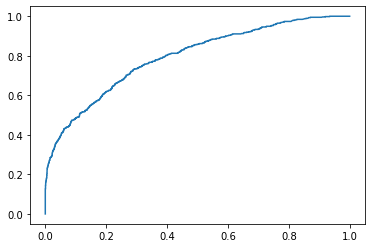

In [31]:
import matplotlib.pyplot as plt
fpr, tpr, thresholds = roc_curve(y_train, model.predict_proba(X_train)[:, 1])
auc = pd.DataFrame(data = [fpr, tpr, thresholds])
auc.rename(index={0:'lažne uzbune',1:'odziv', 2:'thresholds'}, 
                 inplace=True)
plt.plot(fpr, tpr)

In [32]:
auc.T

,lažne uzbune,odziv,thresholds
0,0.000000,0.000000,1.771324
1,0.000000,0.001751,0.771324
2,0.000000,0.126095,0.415187
3,0.000717,0.126095,0.406559
4,0.000717,0.140105,0.386212
...,...,...,...
1327,0.996417,1.000000,0.035889
1328,0.996895,1.000000,0.035216
1329,0.997850,1.000000,0.033141
1330,0.998328,1.000000,0.033098


In [33]:
y_hat = model.predict_proba(X_test)[:, 1] >= 0.1
print(f'Accuracy: {accuracy_score(y_test, y_hat)}')
print(f'Precision: {precision_score(y_test, y_hat)}')
print(f'Recall: {recall_score(y_test, y_hat)}')
print(f'F1: {f1_score(y_test, y_hat)}')

Accuracy: 0.5686274509803921
Precision: 0.2129538763493621
Recall: 0.735593220338983
F1: 0.3302891933028919


In [34]:
confusion_matrix(y_true=y_test, y_pred=y_hat)

array([[943, 802],
       [ 78, 217]], dtype=int64)

Pomeranjem granice model je uspeo da identifikuje defektna vozila i odziv je postao znatno veći.

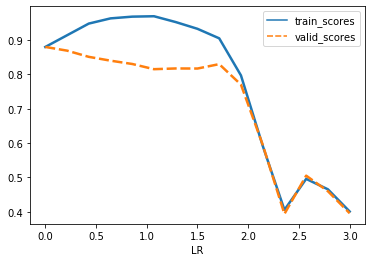

In [35]:
from sklearn.model_selection import validation_curve
import seaborn as sns

params = {'LR':np.linspace(start=0.001, stop=3, num=15)}
train_scores, valid_scores = validation_curve(GradientBoostingClassifier(), X_train, y_train, "learning_rate", params['LR'],cv=10)

viz = pd.DataFrame([np.array(params['LR']),train_scores.mean(axis=1),valid_scores.mean(axis=1)]).T
viz.columns = ['LR','train_scores','valid_scores']
viz = viz.set_index('LR')
sns.lineplot(data=viz, palette="tab10", linewidth=2.5)

Grafik iznad pokazuje kako kreće ocena na train i test modelu (što je veća to je bolje). Ovde se uočava da povećanjem Learning rate parametra do 1.5 model pokazuje bolje rezultate na treningu što prati i rezultat validacije, nakon toga rezultati za trening i test postaju sve bliži i onda naglo opadaju jer je learning rate parametar preveliki i ne uspeva da dođe do boljeg rešenja. Optimalna vrednost ovog parametra bi bila malo ispred mesta gde se ove dve krive krive spajaju (oko 1.75) jer se tako izbegava slučaj pretreniranja. 